In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
BOARD_ROWS = 3
BOARD_COLS = 3

In [29]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1
        self.result = []
    
    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        return self.boardHash
    
    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == 3:
            self.isEnd = True
            return 1
        if diag_sum == -3:
            self.isEnd = True
            return -1
        
        # tie
        # no available actions
        if len(self.availableActions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    def availableActions(self):
        actions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    actions.append((i, j))  # need to be tuple
        return actions
    
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
    
    # only when game ends
    def giveReward(self,current_state,current_action,previous_state,previous_action):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1,current_state,current_action,previous_state,previous_action)
            self.p2.feedReward(0,current_state,current_action,previous_state,previous_action)
        elif result == -1:
            self.p1.feedReward(0,current_state,current_action,previous_state,previous_action)
            self.p2.feedReward(1,current_state,current_action,previous_state,previous_action)
        else:
            self.p1.feedReward(0.1,current_state,current_action,previous_state,previous_action)
            self.p2.feedReward(0.5,current_state,current_action,previous_state,previous_action)
    
    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
    
    def play(self, rounds=100):
        for i in range(rounds):
            if i%1000 == 0:
                print("Rounds {}".format(i))
                self.result.append({"Rounds":i,"P1 Wins":self.p1.win,"P2 Wins":self.p2.win,"Draw":self.p1.draw})
            p1_previous_action = None
            p2_previous_action = None
            previous_state = None
            while not self.isEnd:
                # Player 1
                actions = self.availableActions()
                p1_current_action = self.p1.chooseAction(actions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_current_action)
                current_state = self.getHash()
                self.p1.addState(current_state)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    if win == 1:
                        #print(self.p1.name, "wins!\n")
                        self.p1.win = self.p1.win + 1
                    else:
                        #print("tie!\n")
                        self.p1.draw = self.p1.draw + 1
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward(current_state,p1_current_action,previous_state,p1_previous_action)
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    actions = self.availableActions()
                    p2_current_action = self.p2.chooseAction(actions, self.board, self.playerSymbol)
                    self.updateState(p2_current_action)
                    current_state = self.getHash()
                    self.p2.addState(current_state)
                    win = self.winner()
                    if win is not None:
                        if win == -1:
                            #print(self.p2.name, "wins!\n")
                            self.p2.win = self.p2.win + 1
                            
                        else:
                            #print("tie!\n")
                            self.p2.draw = self.p2.draw + 1
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward(current_state,p2_current_action,previous_state,p2_previous_action)
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
                previous_state = current_state
                p1_previous_action = p1_current_action
                p2_previous_action = p2_current_action

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

In [30]:
class Player:
    def __init__(self, name, exp_rate=0.50):
        self.name = name
        self.states = []  # record all actions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.win = 0
        self.draw = 0
        self.Q_values = {} 
    
    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
        return boardHash
    
    def chooseAction(self, actions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(actions))
            action = actions[idx]
        else:
            value_max = -999
            for a in actions:
                next_board = current_board.copy()
                next_board[a] = symbol
                next_boardHash = self.getHash(next_board)
                if next_boardHash in self.Q_values:
                    if a in self.Q_values[next_boardHash]:
                        value = self.Q_values[next_boardHash][a]
                    else:
                        value = 0
                else:
                    value = 0
                if value >= value_max:
                    value_max = value
                    action = a
        # print("{} takes action {}".format(self.name, action))
        return action
    
    # append a hash state
    def addState(self, state):
        self.states.append(state)
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward,current_state,current_action,previous_state,previous_action):
        if self.Q_values.get(current_state) is None:
            self.Q_values[current_state] = {current_action:0}

        if self.Q_values.get(previous_state) is None:
            self.Q_values[previous_state] = {previous_action:0}

        if current_action in self.Q_values[current_state] and previous_action in self.Q_values[previous_state]:
            self.Q_values[previous_state][previous_action] = self.Q_values[previous_state][previous_action] + \
            self.lr * (reward + self.decay_gamma*(self.Q_values[current_state][current_action]) - self.Q_values[previous_state][previous_action])
        if self.exp_rate > 0.01:
            self.exp_rate *= 0.999
    def reset(self):
        self.states = []

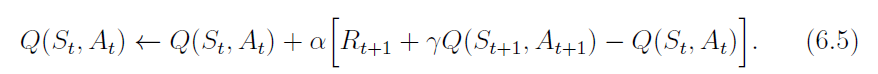

In [31]:
def createPlots(result):
    df = pd.DataFrame(result)
    sns.set_style("whitegrid")
    df1 = pd.DataFrame({
        'Rounds': df['Rounds'].tolist(),
        'P1 Wins': df['P1 Wins'].tolist(),
        'P2 Wins': df['P2 Wins'].tolist(),
        'Draw': df['Draw'].tolist(),
    })
    fig, ax1 = plt.subplots(figsize=(12, 8))
    data = df1.melt(id_vars='Rounds').rename(columns=str.title)
    sns.lineplot(x='Rounds', y='Value', hue='Variable', data=data, ax=ax1,ci=None,palette='dark',style='Variable',
        markers=True, dashes=False)
    sns.despine(fig)

    ax1.set_ylabel('Wins / Draws',fontsize=13)
    ax1.set_xlabel('Rounds',fontsize=13)
    ax1.set_title('TIC TAC TOE USING SARSA: ON-POLICY TD CONTROL',fontsize=16)

    ax1.legend(bbox_to_anchor=(1.12,0.5), loc="center right",  
               bbox_transform=fig.transFigure,fontsize=12, fancybox=True)

    ax1.patch.set_edgecolor('black')  
    ax1.patch.set_linewidth('1') 

In [32]:
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("training...")
st.play(5000)

training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000


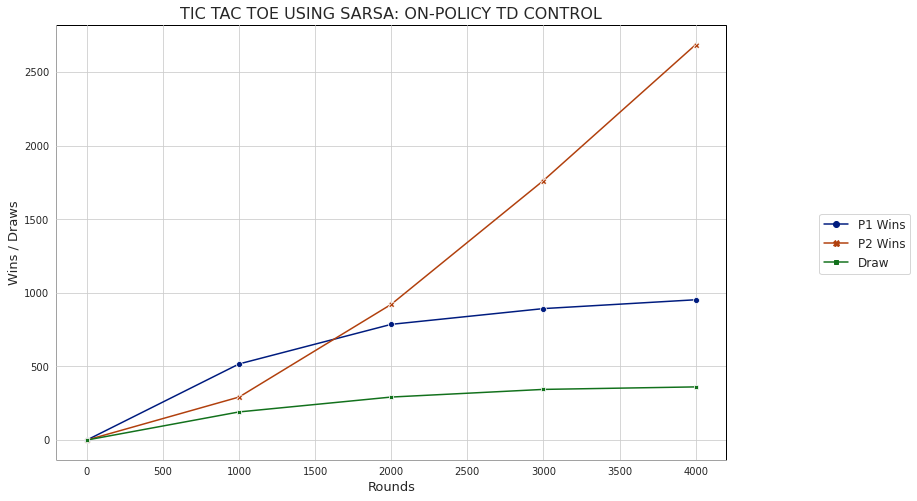

In [33]:
createPlots(st.result)

In [34]:
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("training...")
st.play(50000)

training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


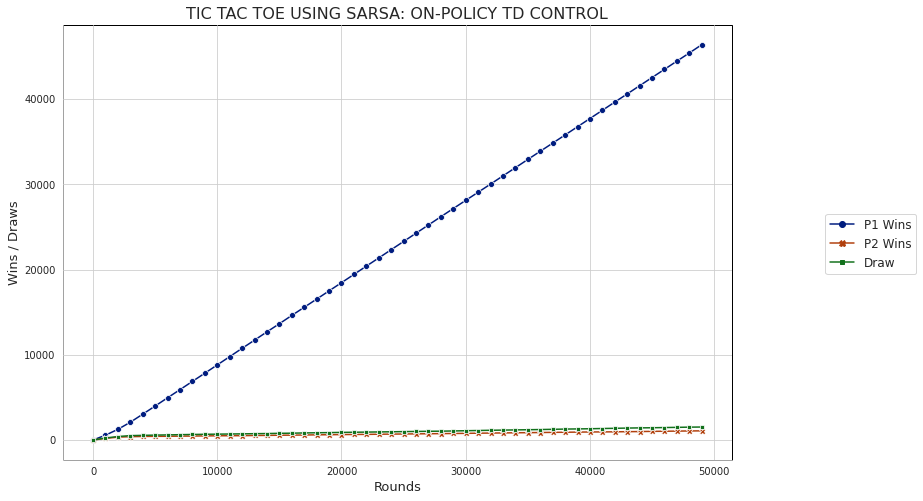

In [35]:
createPlots(st.result)